# Plots for Needle in Haystack Tests

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

import logging
import pickle
from datetime import datetime
import os
from data_processing import gen_ckpt_steps
from conv_plots_funcs import get_seg_starts_per_config
import torch
import gc

#### Experiment Details

In [3]:
valA = "ortho"
valC = "_ident_C"
state_dim = 10
ckpt_step = 141000
experiment = "250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = False

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
errs_loc = errs_dir + f"/needle_{datasource}_" + f"{valA}_state_dim_{state_dim}_"
seg_ext_errs_loc = errs_dir + f"/needle_{datasource}_fin_seg_ext_" + f"{valA}_state_dim_{state_dim}_"


quartiles_file = model_dir + experiment + "/needles/quartiles.npz"

seg_ext_quartiles_file = model_dir + experiment + "/needles/seg_ext_quartiles.npz"

if os.path.exists(quartiles_file):
    print(f"Loading quartiles from {quartiles_file}")
    quartiles = np.load(quartiles_file)

if os.path.exists(seg_ext_quartiles_file):
    print(f"Loading seg ext quartiles from {seg_ext_quartiles_file}")
    seg_ext_quartiles = np.load(seg_ext_quartiles_file)


print(f"Errors location: {errs_loc}")

Loading quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/quartiles.npz
Loading seg ext quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/seg_ext_quartiles.npz
Errors location: ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_ident_C_step=141000.ckpt/needle_val_ortho_state_dim_10_


#### load the err_lss_examples at path which is numpy array

In [15]:
with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
    err_lss_examples = pickle.load(f)

with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
    seg_ext_err_lss_examples = pickle.load(f)

In [16]:
for key in err_lss_examples.keys():
    print(f"shape of examples[{key}]: {err_lss_examples[key].shape}")

for key in seg_ext_err_lss_examples.keys():
    print(f"shape of seg_ext_examples[{key}]: {seg_ext_err_lss_examples[key].shape}")

shape of examples[MOP]: (200, 19, 2000, 251)
shape of examples[Zero]: (200, 19, 2000, 251)
shape of examples[Kalman_rem]: (200, 19, 2000, 251)
shape of examples[Analytical_Kalman]: (200, 19, 251)
shape of examples[Analytical_Simulation]: (200, 19, 2000, 251)
shape of examples[OLS_ir_1]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_1]: (200, 19, 2000, 251)
shape of examples[OLS_ir_2]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_2]: (200, 19, 2000, 251)
shape of examples[OLS_ir_3]: (200, 19, 2000, 251)
shape of examples[OLS_analytical_ir_3]: (200, 19, 2000, 251)
shape of seg_ext_examples[MOP]: (200, 1, 2000, 251)
shape of seg_ext_examples[Zero]: (200, 1, 2000, 251)
shape of seg_ext_examples[Kalman_rem]: (200, 1, 2000, 251)
shape of seg_ext_examples[Analytical_Kalman]: (200, 1, 251)
shape of seg_ext_examples[Analytical_Simulation]: (200, 1, 2000, 251)
shape of seg_ext_examples[OLS_ir_1]: (200, 1, 2000, 251)
shape of seg_ext_examples[OLS_analytical_ir_1]: (200, 1, 

#### Compute the Quartiles

In [5]:
def comp_quartiles(err_lss_examples, ratio=False, train_conv=False, kal_err=None):
    quartiles = {}
    if ratio:
        if not train_conv:
            kal_err = err_lss_examples["Kalman_rem"]

    for key in err_lss_examples.keys():
        if not (key == "Analytical_Kalman" or key == "Kalman_rem" or key == "Kalman"):
            if ratio:
                rat = err_lss_examples[key] / kal_err
            else:
                rat = err_lss_examples[key]
            med = np.median(rat, axis=2)
            # print(f"shape of med: {med.shape}")
            quartiles[key] = np.percentile(med, [25,50,75], axis=0)
            # print(f"shape of quartiles[{key}]: {quartiles[key].shape}")
            
    return quartiles


In [18]:
if valA == "gaussA":
    rat = True
else:
    rat = False
quartiles = comp_quartiles(err_lss_examples, ratio=rat)

#save quartiles to npz file
os.makedirs(os.path.dirname(quartiles_file), exist_ok=True)
np.savez(quartiles_file, **quartiles)

/tmp/ipykernel_770068/341765924.py:11: RuntimeWarning: invalid value encountered in divide
  rat = err_lss_examples[key] / kal_err


shape of med: (200, 19, 251)
shape of quartiles[MOP]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[Zero]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[Analytical_Simulation]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_1]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_1]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_2]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_2]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_ir_3]: (3, 19, 251)
shape of med: (200, 19, 251)
shape of quartiles[OLS_analytical_ir_3]: (3, 19, 251)


In [19]:
seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)

#save seg_ext_quartiles to npz file
os.makedirs(os.path.dirname(seg_ext_quartiles_file), exist_ok=True)
np.savez(seg_ext_quartiles_file, **seg_ext_quartiles)

/tmp/ipykernel_770068/341765924.py:11: RuntimeWarning: invalid value encountered in divide
  rat = err_lss_examples[key] / kal_err


shape of med: (200, 1, 251)
shape of quartiles[MOP]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Zero]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[Analytical_Simulation]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_1]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_1]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_2]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_2]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_ir_3]: (3, 1, 251)
shape of med: (200, 1, 251)
shape of quartiles[OLS_analytical_ir_3]: (3, 1, 251)


## Plotting Code

### final trace

In [3]:
haystack_len = quartiles["MOP"].shape[1]

print(f"quartiles[mop] shape: {quartiles['MOP'].shape}, seg_ext_quartiles[mop] shape: {seg_ext_quartiles['MOP'].shape}")

print(f"haystack_len: {haystack_len}")

quartiles[mop] shape: (3, 19, 251), seg_ext_quartiles[mop] shape: (3, 1, 251)
haystack_len: 19


real_steps: [230, 231, 239], real_steps_ext: [228, 229, 237]
key_count: 0
needle: 0, step: 1, real_step: 230
y: 1.7025214032302114
needle: 0, step: 2, real_step: 231
y: 1.9053346265414755
needle: 0, step: 10, real_step: 239
y: 1.504156483207741
key_count: 1
needle: 0, step: 1, real_step: 230
y: 2.5683659998943824
needle: 0, step: 2, real_step: 231
y: 2.5726403005280605
needle: 0, step: 10, real_step: 239
y: 2.567371872052572
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 0
needle: 1, step: 1, real_step: 230
y: 1.726374191665749
needle: 1, step: 2, real_step: 231
y: 1.5935481080871483
needle: 1, step: 10, real_step: 239
y: 1.3990623182247557
key_count: 1
needle: 1, step: 1, real_step: 230
y: 2.5683659998943824
needle: 1, step: 2, real_step: 231
y: 2.5726403005280605
needle: 1, step: 10, real_step: 239
y: 2.567371872052572
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 2
key_count: 0
needle: 

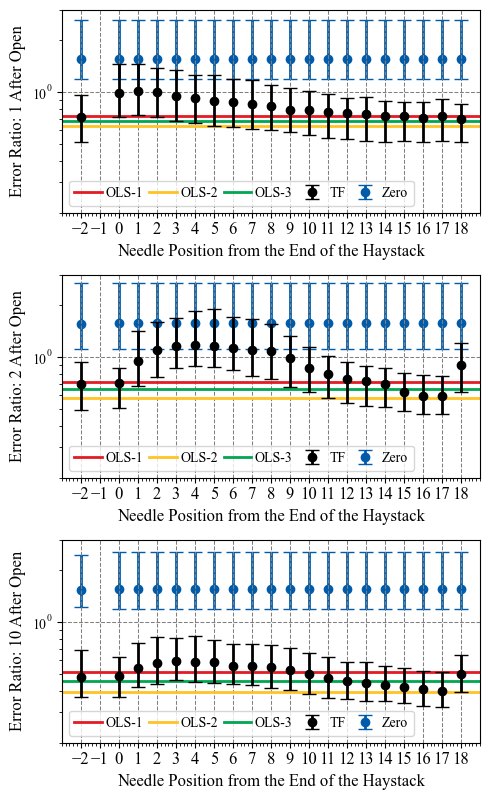

In [5]:
steps_in = [1,2,10]
open_paren_ind = 229
real_steps = [x + open_paren_ind for x in steps_in]
real_steps_ext = [x + open_paren_ind-2 for x in steps_in]

fig, ax = plt.subplots(len(steps_in), 1, sharex=True, figsize=(5, 2.7*len(steps_in))) #

#get a high contrast color map
colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

print(f"real_steps: {real_steps}, real_steps_ext: {real_steps_ext}")


for needle in range(haystack_len):
    key_count = 0
    for key in quartiles.keys():
        print(f"key_count: {key_count}")
        if "OLS" not in key and "Simulation" not in key:
            # ax[needle].scatter(quartiles[key][1, needle], label=key)
            step_count = 0
            for step in steps_in:

                key_label = "TF" if key == "MOP" else key

                print(f"needle: {needle}, step: {step}, real_step: {real_steps[step_count]}")

                y = quartiles[key][1, needle, real_steps[step_count]]
                print(f"y: {y}")
                if valA == "gaussA":
                    y -= 1
                yerr = [
                    quartiles[key][1, needle, real_steps[step_count]] - quartiles[key][0, needle, real_steps[step_count]],
                    quartiles[key][2, needle, real_steps[step_count]] - quartiles[key][1, needle, real_steps[step_count]]
                ]#

                yerr = np.array([[yerr[0]], [yerr[1]]])
                if valA == "gaussA":
                   ax[step_count].errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=f"{key_label}" if needle == 0 else "_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=colors[key_count],
                    linewidth=2
                    )
                else:
                    if key == "Zero":
                        color = colors[1]
                    elif step == 1:
                        color = colors[0]
                    elif step == 2:
                        color = colors[2]
                    elif step == 10:
                        color = colors[3]
                    ax.errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=((f"{key_label}" + (f": {step} After Open" if key == "MOP" else "")) if (needle == 0 and key == "MOP") or (needle == 0 and step == 1) else "_nolegend_"),
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=color,
                    linewidth=2
                    )

                step_count += 1
            key_count += 1

key_count = 0
for key in seg_ext_quartiles.keys():
    if "OLS" not in key and "Simulation" not in key:
        step_count = 0
        for step in steps_in:
            y = seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            if valA == "gaussA":
                y -= 1
            yerr = [
                seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][0, 0, real_steps_ext[step_count]],
                seg_ext_quartiles[key][2, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            ]

            yerr = np.array([[yerr[0]], [yerr[1]]])
            
            if valA == "gaussA":
                ax[step_count].errorbar(
                    -2,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label="_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color = colors[key_count], 
                    linewidth=2
                )
            else:
                if key == "Zero":
                    color = colors[1]
                elif step == 1:
                    color = colors[0]
                elif step == 2:
                    color = colors[2]
                elif step == 10:
                    color = colors[3]
                ax.errorbar(
                    -2 + step_count*0.02,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label="_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color = color, 
                    linewidth=2
                )

            if valA != "gaussA":
                ax.legend(fontsize = 8, ncol=1, columnspacing=0.25)#, loc="upper left")
                ax.set_xlabel("Needle Position from the End of the Haystack", fontsize=12, fontname="Times New Roman")
                ax.set_ylabel(("(" if valA== "gaussA" else "") + "Error" + (" Ratio" if valA == "gaussA" else ""), fontsize=12)
                ax.set_xlim(-3, haystack_len)
                ax.grid(True)
                ax.minorticks_on()
                ax.grid(which='major', linestyle='--', linewidth='0.75', color='gray')
                # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
                #set the grid to be on integer values for x-axis
                ax.set_xticks(np.arange(-2, haystack_len, 1))
                ax.set_yscale('log')
                # ax[step_count].set_ylim(0.3, 3)
                ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=12)

            step_count += 1
        key_count += 1

if valA == "gaussA":
    for key in quartiles.keys():
        if "OLS" in key and "analytical" not in key:
            print(f"key_count: {key_count}")
            print(f"quartiles[{key}].shape: {quartiles[key].shape}")
            step_count = 0
            for step in steps_in:
                y = quartiles[key][1, :, real_steps[step_count]]
                y -= 1
                ax[step_count].axhline(y[0], label=key[:3] + "-" + key[7:], color=colors[key_count], linewidth=2, linestyle='-')


                ax[step_count].legend(fontsize = 10, ncol=5, columnspacing=0.4, handletextpad=0.25)#, loc="upper left")
                ax[step_count].set_xlabel("Needle Position from the End of the Haystack", fontsize=12, fontname="Times New Roman")
                ax[step_count].set_ylabel("Error" + (" Ratio" if valA == "gaussA" else "") + f": {step} After Open", fontsize=12)
                ax[step_count].set_xlim(-3, haystack_len)
                ax[step_count].grid(True)
                ax[step_count].minorticks_on()
                ax[step_count].grid(which='major', linestyle='--', linewidth='0.75', color='gray')
                # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
                #set the grid to be on integer values for x-axis
                ax[step_count].set_xticks(np.arange(-2, haystack_len, 1))
                ax[step_count].set_yscale('log')
                ax[step_count].set_ylim([2e-1, 3])
                ax[step_count].tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
                step_count += 1
            key_count += 1


fig.tight_layout()

plt.show()

os.makedirs(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}", exist_ok=True)
fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/error_ratios_{valA}_state_dim_{state_dim}{valC}_step_{ckpt_step}.pdf", transparent=True)



In [7]:
if valA == "gaussA":
    quartilez_npz = quartiles
    seg_ext_quartiles_npz = seg_ext_quartiles
    quartiles = {key: quartiles[key] for key in quartiles.keys()}
    seg_ext_quartiles = {key: seg_ext_quartiles_npz[key] for key in seg_ext_quartiles_npz.keys()}
    for key in quartiles.keys():
        seg_ext_quartiles[key] -= 1
        quartiles[key] -= 1

haystack_len: 19


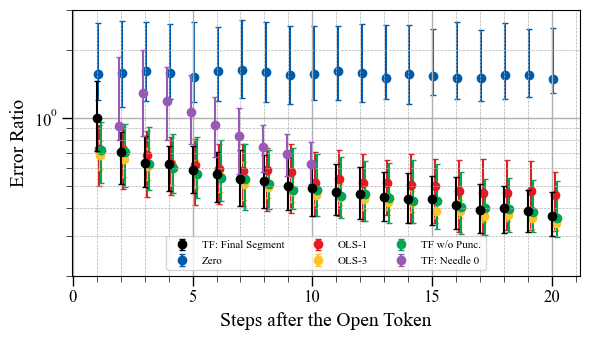

In [8]:
#make a figure with haystack_len subplots
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3.5))
# fig, ax = plt.subplots(haystack_len, 1, sharex=True, figsize=(5, 5*haystack_len))

colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

col_count = 0
dither = 0.05

open_paren_ind = 229
fin_seg_len = 250-open_paren_ind -1
x_values = np.arange(1, fin_seg_len+1)

print(f"haystack_len: {haystack_len}")
ax_count = 0
needle = haystack_len - 1
for key in quartiles.keys():
    if "OLS_analytical" not in key and "Simulation" not in key and key != "OLS_ir_2":
        ax.errorbar(x_values + col_count*dither, quartiles[key][1, needle][open_paren_ind+1:-1], yerr=[quartiles[key][1, needle][open_paren_ind+1:-1] - quartiles[key][0, needle][open_paren_ind+1:-1], quartiles[key][2, needle][open_paren_ind+1:-1] - quartiles[key][1, needle][open_paren_ind+1:-1]], fmt='o', label="TF: Final Segment" if key == "MOP" else (key[:3] + "-" + key[7:] if "OLS" in key else f"{key}"), capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
        col_count += 1

needle = 0
# for key in seg_ext_quartiles.keys():
#     if "OLS_analytical" not in key:



y_values = seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]
yerr_lower = seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len] - seg_ext_quartiles["MOP"][0, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]
yerr_upper = seg_ext_quartiles["MOP"][2, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len] - seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]

ax.errorbar(x_values + dither*col_count, y_values, yerr=[yerr_lower, yerr_upper], fmt='o', label=f"TF w/o Punc.", capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
col_count += 1

needle = 0 #get the first needle
open_paren_ind = 1
key = "MOP"

fin_seg_len = 10

ax.errorbar(x_values[:10] + -dither, quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len], yerr=[quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len] - quartiles[key][0, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len], quartiles[key][2, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len] - quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len]], fmt='o', label="TF: Needle 0", capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
col_count += 1
        
ax.legend(ncol=3 if valA == "gaussA" else 1, fontsize=8)
ax.grid(which="both")
# ax.set_xlim(left=230, right=seg_ext_quartiles[key].shape[-1] - 1)  # set the x axis limits haystack_len*12 + 2
# ax.set_ylim(bottom=0, top=5.5)  # set the y axis limits

# Optionally, customize major and minor ticks
ax.minorticks_on()

# Set minor vertical grid lines to be on intervals of 1
# Set major ticks on every interval of 50
ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 5))

# Set minor vertical grid lines to be on intervals of 1
ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 1), minor=True)

ax.tick_params(axis='both', which='major', length=7, width=1, labelsize=12)
ax.tick_params(axis='both', which='minor', length=4, width=0.5, labelsize=0)
ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
ax.grid(which='major', linestyle='-', linewidth=1)
ax.grid(which='minor', linestyle='--', linewidth=0.5)
ax.set_ylabel(f"Error" + (" Ratio" if valA == "gaussA" else ""), fontsize=14)
ax.set_xlabel("Steps after the Open Token", fontsize=14)
ax.set_yscale('log')
# ax.set_title(f"Prediction Error for Needle Position {needle}", fontsize=30)
if valA == "gaussA":
    ax.set_ylim([2e-1, 3])

#add the date and time to the filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# #add a caption to the bottom of the figure
# fig.text(0.5, 0.1, f"Median of {num_examples} haystack configuration examples. step=" + str(ckpt_step) + "_" + timestamp, ha='center', fontsize=30)
plt.tight_layout()

fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/last_seg_context_{valA}.pdf", transparent=True)

# Needle in a Haystack: Training Convergence

In [16]:
minval = 3000
maxval = 105000
interval = 3000
ckpt_steps = gen_ckpt_steps(minval, maxval, interval)
batch_size = 512
gpus=2

kal_ckpt = 126000
kal_err = None

if valA == "gaussA":
    rat = True
else:
    rat = False

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

haystack_len = 1

train_conv_fin_quartiles_file = model_dir + experiment + f"/needles/train_conv/train_conv_fin_quartiles_haystack_len_{haystack_len}.pkl"
train_conv_beg_quartiles_file = model_dir + experiment + f"/needles/train_conv/train_conv_beg_quartiles_haystack_len_{haystack_len}.pkl"
x_values_file = model_dir + experiment + f"/needles/train_conv/x_values_haystack_len_{haystack_len}.npy"



if os.path.exists(train_conv_fin_quartiles_file):
    print(f"Loading train conv quartiles from {train_conv_fin_quartiles_file}")
    with open(train_conv_fin_quartiles_file, "rb") as f:
        fin_quartiles_ckpt = pickle.load(f)

if os.path.exists(train_conv_beg_quartiles_file):
    print(f"Loading train conv quartiles from {train_conv_beg_quartiles_file}")
    with open(train_conv_beg_quartiles_file, "rb") as f:
        beg_quartiles_ckpt = pickle.load(f)

if os.path.exists(x_values_file):
    x_values = np.load(x_values_file)

ckpt_steps: [3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000, 30000, 33000, 36000, 39000, 42000, 45000, 48000, 51000, 54000, 57000, 60000, 63000, 66000, 69000, 72000, 75000, 78000, 81000, 84000, 87000, 90000, 93000, 96000, 99000, 102000, 105000]
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl


In [ ]:
steps_in = [1,2,3,5,10]

fig, ax = plt.subplots(max(2,haystack_len), 1, sharex=True, figsize=(5, 5))


quartiles_ckpt = []
pred_ckpts = []
last_pred_ckpt = 0
x_values = []
ys = {}
y_errs = {}
fin_quartiles_ckpt = {}
beg_quartiles_ckpt = {}

if valA == "gaussA":
    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={kal_ckpt}.ckpt"
    # errs_loc = errs_dir + f"/single_system_" + f"{valA}_state_dim_{state_dim}_" 
    errs_loc = errs_dir + f"/train_conv_needle_haystack_len_{haystack_len}_{datasource}_" + f"{valA}_state_dim_{state_dim}_"

    with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            kal_ckpt_errs = pickle.load(f)

    kal_err = kal_ckpt_errs["Kalman_rem"]

for ckpt_step in ckpt_steps:

    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
    errs_loc = errs_dir + f"/single_system_" + f"{valA}_state_dim_{state_dim}_"
    errs_loc = errs_dir + f"/train_conv_needle_haystack_len_{haystack_len}_{datasource}_" + f"{valA}_state_dim_{state_dim}_" 

    if os.path.exists(errs_loc + "err_lss_examples.pkl"):
        print(f"loading errors for ckpt_step: {ckpt_step}")

        if len(pred_ckpts) > 0:
            last_pred_ckpt = pred_ckpts[-1]
            
            if valA == "ortho": #THIS IS FOR VANILLA ORTHO ONLY
                gpus = 2 #just for ortho case
            
            elif valA == "ident" and ckpt_step > 9600: #THIS IS FOR VANILLA IDENT ONLY
                gpus = 4

        else:
            last_pred_ckpt = 0
            if valA == "ortho":
                gpus = 3

        with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            err_lss_examples = pickle.load(f)

        # if os.path.exists(seg_ext_errs_loc + "err_lss_examples.pkl"):
        #     with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
        #         seg_ext_err_lss_examples = pickle.load(f)

        if len(pred_ckpts) == 0:
            #get seg_starts
            seg_starts_per_conf = get_seg_starts_per_config(experiment, valA, valC, state_dim, ckpt_step, print_seg_starts=True, nope=nope, needle=True, haystack_len=haystack_len, train_conv=True)

        quartiles = comp_quartiles(err_lss_examples, ratio=rat, train_conv=True, kal_err=kal_err)

        del err_lss_examples
        #clear cuda cache
        torch.cuda.empty_cache()
        gc.collect()

        print(f"batch_size: {batch_size}, gpus: {gpus}, ckpt_step: {ckpt_step}, last_pred_ckpt: {last_pred_ckpt}")
        if len(x_values) > 0:
            x_value = batch_size*gpus*(ckpt_step - last_pred_ckpt) + x_values[-1]
        else:
            x_value = batch_size*gpus*(ckpt_step - last_pred_ckpt)

        print(f"x_value: {x_value}")
        x_values.append(x_value)
        for needle in range(1):
            fin_seg_start = seg_starts_per_conf[needle][-1]
            beg_seg_start = seg_starts_per_conf[needle][0]
            for step in steps_in:
                for key in ["MOP"]:
                    if "OLS_analytical" not in key and key not in  ["Zero", "Analytical_Simulation", "Kalman_rem", "Kalman", "Analytical_Kalman"]:
                        key_lab = "TF" if key == "MOP" else key
                        
                        y = quartiles[key][1, needle, fin_seg_start + step]
                        
                        y_err = [
                            [quartiles[key][1, needle, fin_seg_start + step] - quartiles[key][0, needle, fin_seg_start + step]],
                            [quartiles[key][2, needle, fin_seg_start + step] - quartiles[key][1, needle, fin_seg_start + step]]
                        ]

                        if needle == 0:
                            if len(pred_ckpts) == 0:
                                if step == 1:
                                    ys[key] = {}
                                    y_errs[key] = {}
                                    fin_quartiles_ckpt[key] = {}
                                    beg_quartiles_ckpt[key] = {}

                                    # for ir in range(1,4):
                                    #     ys[f"OLS_ir_{ir}"] = {}
                                    #     y_errs[f"OLS_ir_{ir}"] = {}
                                    #     fin_quartiles_ckpt[f"OLS_ir_{ir}"] = {}
                                    #     beg_quartiles_ckpt[f"OLS_ir_{ir}"] = {}


                                # print("step: ", step)
                                # print(f"key: {key}, step: {step}")
                                ys[key][step] = [y]
                                y_errs[key][step] = [y_err]
                                fin_quartiles_ckpt[key][step] = [quartiles[key][:, needle, fin_seg_start + step]]
                                beg_quartiles_ckpt[key][step] = [quartiles[key][:, needle, beg_seg_start + step]]

                            # elif ckpt_step == kal_ckpt and "OLS" in key:
                            #     ys[key][step] = [y]
                            #     y_errs[key][step] = [y_err]
                            #     fin_quartiles_ckpt[key][step] = [quartiles[key][:, needle, fin_seg_start + step]]
                            #     beg_quartiles_ckpt[key][step] = [quartiles[key][:, needle, beg_seg_start + step]]

                                # print(f"ys: {ys}")
                            else:
                                # print(f"ys: {ys}")
                                # print("step after minval: ", step)
                                # print(f"ys: {ys}")
                                # print(f"key: {key}, step: {step}")
                                ys[key][step].append(y)
                                y_errs[key][step].append(y_err)
                                fin_quartiles_ckpt[key][step].append(quartiles[key][:, needle, fin_seg_start + step])
                                beg_quartiles_ckpt[key][step].append(quartiles[key][:, needle, beg_seg_start + step])

                        ax[needle].errorbar(x_value, y, y_err, label=f"{key}: {step} after open" if ckpt_step == minval else "_nolegend_", capsize=5, markersize=5)

            
            ax[needle].set_xlabel("# of Training Examples", fontsize=12)
            ax[needle].set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else "") + f": Needle Position {needle}", fontsize=12)
            ax[needle].set_yscale('log')
            ax[needle].set_xscale('log')
            ax[needle].grid(True)
            ax[needle].legend(fontsize=8)
            ax[needle].set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)

        pred_ckpts.append(ckpt_step)
    else:
        print(f"path: {errs_loc + "err_lss_examples"} for ckpt_step: {ckpt_step} does not exist.")
   
plt.show()


os.makedirs(os.path.dirname(train_conv_fin_quartiles_file), exist_ok=True)
#save quartiles to pickle file
with open(train_conv_fin_quartiles_file, "wb") as f:
    pickle.dump(fin_quartiles_ckpt, f)

os.makedirs(os.path.dirname(train_conv_beg_quartiles_file), exist_ok=True)
#save quartiles to pickle file
with open(train_conv_beg_quartiles_file, "wb") as f:
    pickle.dump(beg_quartiles_ckpt, f)

os.makedirs(os.path.dirname(x_values_file), exist_ok=True)
np.save(x_values_file, x_values)


        # seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)


findfont: Font family 'Times New Roman' not found.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

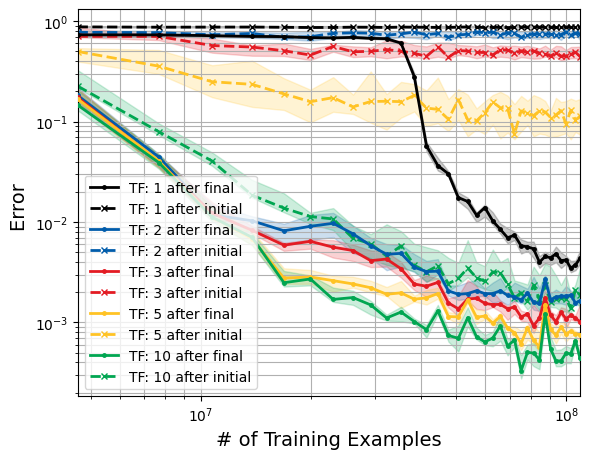

In [17]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4.7))

colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651']

if valA == "ortho":
    steps = [1,2,3,5,10]
else:
    steps = [1,2,3]
for key in fin_quartiles_ckpt.keys():
    if key == "MOP":
        col_count = 0
        for step in steps:

            key_lab = "TF" if key == "MOP" else key
            qs = np.array(fin_quartiles_ckpt[key][step])
            qs = np.transpose(qs)

            if valA == "gaussA":
                qs -= 1

            #if key contains OLS then repeat the values in qs to be the length of x_values
            if "OLS" in key:
                print(f"key: {key} qs shape: {qs.shape}")
                qs = np.repeat(qs, len(x_values), axis=0)
                print(f"qs shape after repeat: {qs.shape}")
            ax.plot(x_values, qs[1], label=f"{key_lab}: {step} after final", markersize=5, marker=".", zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
            if not valA == "gaussA":
                ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

            beg_qs = np.array(beg_quartiles_ckpt[key][step])
            beg_qs = np.transpose(beg_qs)
            #set the color to the same as the fin quartiles
            color = ax.get_lines()[-1].get_color()
            ax.plot(x_values, beg_qs[1], label=f"{key_lab}: {step} after initial", markersize=5, marker="x", color=color, linestyle="--", linewidth=2)

            if not valA == "gaussA":
                ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

            col_count += 1


ax.set_xlabel("# of Training Examples", fontsize=14)
ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else ""), fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True, which="both")
ax.legend(fontsize=10, ncol=2 if valA =="ident" else 1, loc="lower left")
ax.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
# ax.set_ylim([5e-2, 3e0])
# ax.set_title(("Ortho" if valA == "ortho" else ("Gaussian" if valA == "gaussA" else "Identity")) + f" Haystack Length: {haystack_len} vs Training Examples")
plt.tight_layout()

fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/{valA}_train_conv_haystack_len_{haystack_len}.pdf", transparent=True, format="pdf")

plt.show()

In [14]:
print(qs)

[[0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887
  0.10777887 0.10777887 0.10777887 0.10777887 0.10777887 0.10777887]
 [0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0.12513957 0.12513957
  0.12513957 0.12513957 0.12513957 0.12513957 0

## haystack length plot

In [15]:
from haystack_plots import load_quartiles_ckpt_files
from get_last_checkpoint import split_path
import re

In [16]:
def extract_trace_string(file_path):
    match = re.search(r'trace_(.*?)_state', file_path)
    if match:
        return match.group(1)
    else:
        return None

def haystack_len_plot(experiment_paths, model_sizes, colors):
    exp_count = 0
    for experiment_path in experiment_paths:
        valA = extract_trace_string(experiment_path)
        model_size = model_sizes[exp_count]
        nope = "NoPE" in experiment_path

        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4.7))

        haystack_lens = np.arange(1,19)

        # model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

        dither = 0.05

        # experiment = "250125_104123.f75c04_multi_sys_trace_ortho_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000"

        model_dir, experiment = split_path(experiment_path)

        for haystack_len in haystack_lens:
            print("haystack_len: ", haystack_len)
            train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(haystack_len, model_dir, experiment)

            steps = fin_quartiles_ckpt["MOP"].keys() #get the steps in from open token

            step_count = 0
            for step in steps:
                print(f"step: {step}")
                qs = np.array(fin_quartiles_ckpt["MOP"][step]).T
                print(f"qs shape: {qs.shape}")

                if valA == "gaussA":
                    qs -= 1

                    # ax.scatter(haystack_len + dither*step_count*(-1**step_count), qs[1,last_ind], label=f"TF: {step} after final" if haystack_len == 1 else "_nolegend_", s=100, marker=".", color=colors[step_count])

                last_ind = len(qs[1]) - 1
                print(f"\nx_value at last index: {x_values[last_ind]} for haystack_len: {haystack_len} and step: {step}\n")
                    
                ax.errorbar(haystack_len + dither*step_count*(-1**step_count), qs[1,last_ind], yerr=[[qs[1,last_ind] - qs[0,last_ind]], [qs[2,last_ind] - qs[1,last_ind]]], label=f"TF: {step} after final" if haystack_len == 1 else "_nolegend_", markersize=8, marker=".", color=colors[step_count], capsize=5, linewidth=2)
                    
                step_count += 1

        ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 5))

        # Set minor vertical grid lines to be on intervals of 1
        ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 1), minor=True)


        ax.set_xlabel("Haystack Length", fontsize=14)
        ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else ""), fontsize=14)
        ax.set_yscale('log')
        ax.grid(True, which="both")
        ax.legend(fontsize=10)
        ax.set_xlim(0, 20)
        ax.set_title(("NoPE " if nope else "") + ("Orthogonal " if valA == "ortho" else ("Gaussian " if valA == "gaussA" else "Identity ")) + f"Error vs Haystack Length: {model_size} Model")

                
        fig.savefig(experiment_path + f"/figures/multi_sys_trace/{valA}_haystack_len_plot.pdf", transparent=True, format="pdf")
        exp_count += 1
    return None

In [17]:
colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']
experiment_paths = ["../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2_NoPE/250124_190131.5710d5_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2_NoPE/250125_092007.f34194_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000"]

model_sizes = ["Medium", "Medium", "Medium", "Medium", "Medium", "Medium"]

valA = extract_trace_string(experiment_paths[2])
print(f"valA: {valA}")

print(f"is NoPE in experiment_paths[0]: {'NoPE' in experiment_paths[3]}")


valA: ident
is NoPE in experiment_paths[0]: True


haystack_len:  1
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250112_043028.07172b_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
step: 1
qs shape: (3, 34)

x_value at last index: 105984000 for haystack_len: 1 and step: 1

step: 2
qs shape: (3, 34)

x_value at last index: 105984000 for haystack_len: 1 and step: 2

step: 3
qs shape: (3, 34)

x_value at last index: 105984000 for haystack_len: 1 and step: 3

step: 5
qs shape: (3, 34)

x_value at last index: 105984000 for haystack_len: 1 and step: 5

step: 10
qs shape: (3, 34)

x_value at last index: 105984000 for haystack_len: 1 and step: 10

haystack_len:  2
Loading train conv quartiles from ../outputs/GPT2/250112_

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

haystack_len:  1
Loading train conv quartiles from ../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
step: 1
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 1 and step: 1

step: 2
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 1 and step: 2

step: 3
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 1 and step: 3

step: 5
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 1 and step: 5

step: 10
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 1 and step: 10

haystack_len:  2
Loading train conv quartiles from ../outputs/GPT2/250

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


step: 3
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 13 and step: 3

step: 5
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 13 and step: 5

step: 10
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 13 and step: 10

haystack_len:  14
Loading train conv quartiles from ../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_14.pkl
Loading train conv quartiles from ../outputs/GPT2/250114_202420.3c1184_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_14.pkl
step: 1
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 14 and step: 1

step: 2
qs shape: (3, 38)

x_value at last index: 184320000 for haystack_len: 14 and step: 2

step: 3
qs shape: (3, 38)

x_value at last index: 184320000 fo

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

haystack_len:  1
Loading train conv quartiles from ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
step: 1
qs shape: (3, 39)

x_value at last index: 26214400 for haystack_len: 1 and step: 1

step: 2
qs shape: (3, 39)

x_value at last index: 26214400 for haystack_len: 1 and step: 2

step: 3
qs shape: (3, 39)

x_value at last index: 26214400 for haystack_len: 1 and step: 3

step: 5
qs shape: (3, 39)

x_value at last index: 26214400 for haystack_len: 1 and step: 5

step: 10
qs shape: (3, 39)

x_value at last index: 26214400 for haystack_len: 1 and step: 10

haystack_len:  2
Loading train conv quartiles from ../outputs/GPT2/250124_05261

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

haystack_len:  1
Loading train conv quartiles from ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2_NoPE/250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
step: 1
qs shape: (3, 41)

x_value at last index: 15974400 for haystack_len: 1 and step: 1

step: 2
qs shape: (3, 41)

x_value at last index: 15974400 for haystack_len: 1 and step: 2

step: 3
qs shape: (3, 41)

x_value at last index: 15974400 for haystack_len: 1 and step: 3

step: 5
qs shape: (3, 41)

x_value at last index: 15974400 for haystack_len: 1 and step: 5

step: 10
qs shape: (3, 41)

x_value at last index: 15974400 for haystack_len: 1 and step: 10

haystack_len:  2
Loading train conv quartiles from ../outputs/GPT2_No

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

haystack_len:  1
Loading train conv quartiles from ../outputs/GPT2_NoPE/250124_190131.5710d5_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2_NoPE/250124_190131.5710d5_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
step: 1
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 1 and step: 1

step: 2
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 1 and step: 2

step: 3
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 1 and step: 3

step: 5
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 1 and step: 5

step: 10
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 1 and step: 10

haystack_len:  2
Loading train conv quartiles from ../outputs/GP

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


Loading train conv quartiles from ../outputs/GPT2_NoPE/250124_190131.5710d5_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_13.pkl
Loading train conv quartiles from ../outputs/GPT2_NoPE/250124_190131.5710d5_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_13.pkl
step: 1
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 13 and step: 1

step: 2
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 13 and step: 2

step: 3
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 13 and step: 3

step: 5
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 13 and step: 5

step: 10
qs shape: (3, 31)

x_value at last index: 205824000 for haystack_len: 13 and step: 10

haystack_len:  14
Loading train conv quartiles from ../outputs/GPT2_NoPE/2

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

haystack_len:  1
Loading train conv quartiles from ../outputs/GPT2_NoPE/250125_092007.f34194_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2_NoPE/250125_092007.f34194_multi_sys_trace_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
step: 1
qs shape: (3, 32)

x_value at last index: 442368000 for haystack_len: 1 and step: 1

step: 2
qs shape: (3, 32)

x_value at last index: 442368000 for haystack_len: 1 and step: 2

step: 3
qs shape: (3, 32)

x_value at last index: 442368000 for haystack_len: 1 and step: 3

step: 5
qs shape: (3, 32)

x_value at last index: 442368000 for haystack_len: 1 and step: 5

step: 10
qs shape: (3, 32)

x_value at last index: 442368000 for haystack_len: 1 and step: 10

haystack_len:  2
Loading train conv quartiles from ../output

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

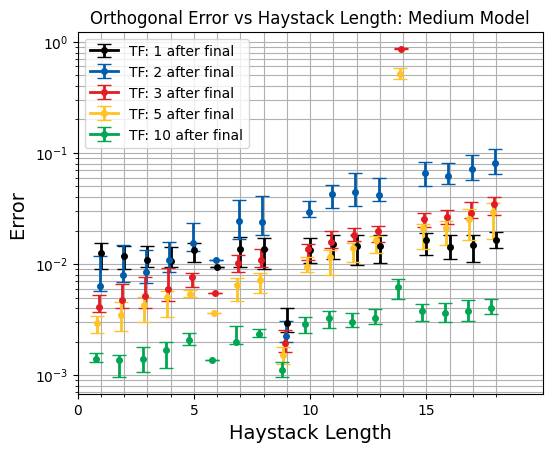

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

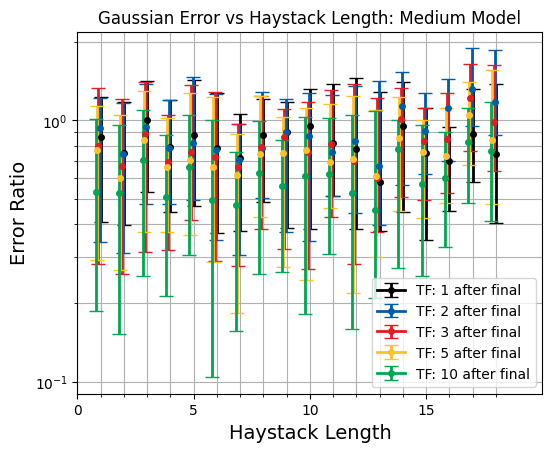

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

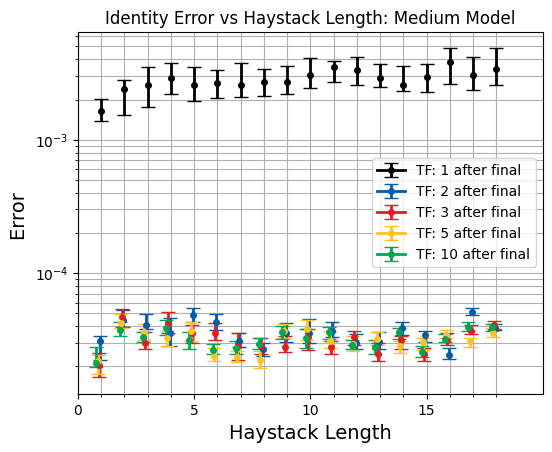

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

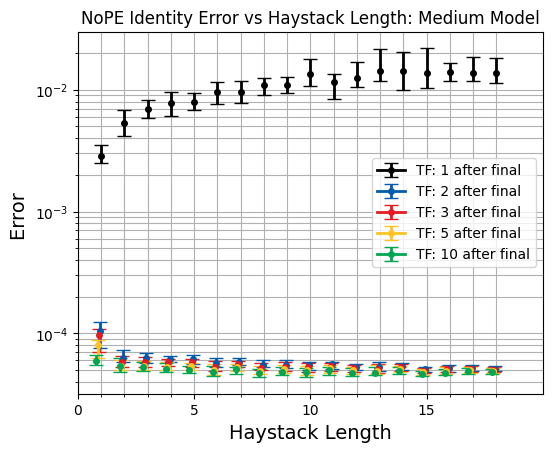

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

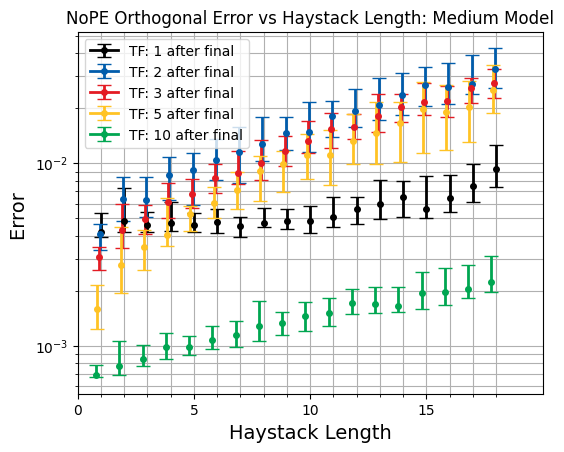

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

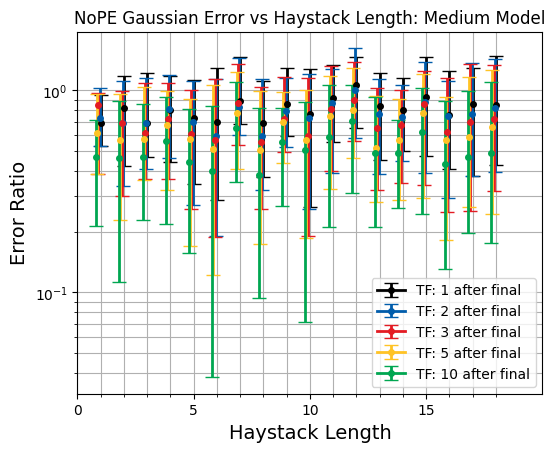

In [18]:
haystack_len_plot(experiment_paths, model_sizes, colors)